In [2]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint

from SVD import Metrics, SVDPredictor
from RecData import RecData

In [3]:
recs = pd.read_csv('data/pruned.csv')
USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

recs.head()

,app_id,is_recommended,user_id
0,534380,True,10531
1,42700,False,185293
2,602960,True,319249
3,976730,False,747545
4,1091500,True,2113544


In [4]:
random.seed(42)
np.random.seed(42)

rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

train_data, test = rec_data.leave_k_out_split()
train_data, val = train_data.leave_k_out_split()

Epoch 0/Training error: 0.3641583764707614/Validation error: 0.36272170656427394/Time: 42.84 seconds
Epoch 1/Training error: 0.35648389724478496/Validation error: 0.35729544975055577/Time: 43.81 seconds
Epoch 2/Training error: 0.35091545346737335/Validation error: 0.3531280525145203/Time: 43.49 seconds
Epoch 3/Training error: 0.34652277571538637/Validation error: 0.34984123734325584/Time: 44.97 seconds
Epoch 4/Training error: 0.34309302218803023/Validation error: 0.347324229709519/Time: 44.03 seconds
Epoch 5/Training error: 0.3403300530828257/Validation error: 0.34526882293805117/Time: 45.15 seconds
Epoch 6/Training error: 0.3380553151176988/Validation error: 0.34377689359658575/Time: 44.56 seconds
Epoch 7/Training error: 0.33619121296558985/Validation error: 0.34256612003543346/Time: 42.99 seconds
Epoch 8/Training error: 0.33458261617166873/Validation error: 0.34150879352953634/Time: 44.32 seconds
Epoch 9/Training error: 0.3332162268779436/Validation error: 0.3406605733810627/Time: 46

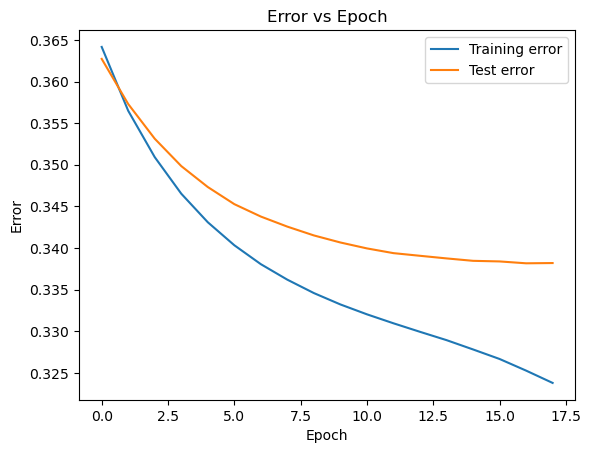

Test rmse 0.3381912961393702
Saving model...
Done saving model.


In [23]:
EPOCHS = 20

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = SVDPredictor(
    train_data.get_num_users(), train_data.get_num_items(), k=100, epochs=EPOCHS, 
    learning_rate=0.005, C=0.02)
svd_predictor.fit(train_data.get_matrix(), validation_set=val)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([svd_predictor, rec_data, train_data, val, test], file)
print("Done saving model.")

In [24]:
# Test top-n list for user 0
top_n = svd_predictor.top_n(0)
print("Predicted top n:")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

# User 0 true top n list
print("True top n:")
true_top = rec_data.top_n(0, 100)
pprint([rec_data.index_to_title(index) for _, index in true_top])

Predicted top n:
[(2.1503570756768067, 'Turing Complete'),
 (2.1372111199003987, 'Dungeon Warfare 2'),
 (2.124058010147192, 'The Case of the Golden Idol'),
 (2.1207284853187103, 'Choice of Robots'),
 (2.1200471528966096, 'Tex Murphy: Under a Killing Moon'),
 (2.117415880723491, 'Lil Gator Game'),
 (2.1155778471417825, 'Glass Masquerade'),
 (2.11430989078215, 'Gunpoint'),
 (2.1129080977216272, 'Hidden & Dangerous 2: Courage Under Fire'),
 (2.1107627641189337, 'Hexcells Infinite')]
True top n:
['Grand Theft Auto IV: The Complete Edition',
 'Fallout: New Vegas',
 'Dying Light',
 '7 Days to Die',
 'American Truck Simulator',
 'RimWorld',
 'DARK SOULS™ II: Scholar of the First Sin',
 'Dead Island Definitive Edition',
 'DRAGON BALL XENOVERSE 2',
 'Satisfactory',
 'Dying Light 2 Stay Human',
 "Assassin's Creed® Origins",
 'Phasmophobia',
 'Halo: The Master Chief Collection',
 'Timberborn',
 'Orcs Must Die! 3']


In [7]:
rec_data.search_title('1330')

[]

In [25]:
prefs = [(606, 1), (1628, 1), (391, 0), (1330, 0), (500, 0), (709, 1), (840, 0), 
         (58, 1), (456, 1), (153, 0), (158, 0), (1160, 0), (761, 0),
                              (1771, 0), (544, 0), (312, 0), (277, 0)]
pprint([(index, rec_data.index_to_title(index), pref) for index, pref in prefs])
prefs = rec_data.create_prefs(prefs)    

[(606, 'Stardew Valley', 1),
 (1628, 'The Sims™ 4', 1),
 (391, 'Mortal Kombat X', 0),
 (1330, 'Mortal Kombat\xa011', 0),
 (500, 'Total War: WARHAMMER', 0),
 (709, 'UNO', 1),
 (840, 'MONOPOLY® PLUS', 0),
 (58, 'SPORE™', 1),
 (456, 'Choice of Robots', 1),
 (153, 'Infested Planet', 0),
 (158, 'Gunpoint', 0),
 (1160, 'Cosmoteer: Starship Architect & Commander', 0),
 (761, 'Glass Masquerade', 0),
 (1771, 'Against the Storm', 0),
 (544, 'Aviary Attorney', 0),
 (312, 'Grand Theft Auto V', 0),
 (277, 'Rust', 0)]


In [20]:
svd_predictor._partial_batch_size = int(0)
start_time = time.time()
svd_predictor.partial_fit(prefs)
print("Completed partial fit in", time.time() - start_time, "seconds")

Epoch 0/Training error: 0.3335227855732511/Time: 3.32 seconds
Epoch 1/Training error: 0.3335216319019268/Time: 3.33 seconds
Epoch 2/Training error: 0.33352083110605046/Time: 3.27 seconds
Epoch 3/Training error: 0.3335202533750534/Time: 3.26 seconds
Epoch 4/Training error: 0.33351985188113237/Time: 3.24 seconds
Completed partial fit in 16.47112774848938 seconds
Predicted top n
[(1.7077738155050715, 'Hexcells Infinite'),
 (1.6895720591944543, 'Lil Gator Game'),
 (1.688066401769133, 'The Case of the Golden Idol'),
 (1.687407148980516, 'Turing Complete'),
 (1.6819600088797104, 'Dungeon Warfare 2'),
 (1.6792200525321865, 'Thief™ II: The Metal Age'),
 (1.6781844619468393, 'Baba Is You'),
 (1.6767923925314212, 'A Hat in Time'),
 (1.6742712744118848, 'Later Alligator'),
 (1.6722390027958658, 'Incredibox')]


In [21]:
top_n = svd_predictor.top_n(train_data.get_matrix().shape[0], 20)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

Predicted top n
[(1.7077738155050715, 'Hexcells Infinite'),
 (1.6895720591944543, 'Lil Gator Game'),
 (1.688066401769133, 'The Case of the Golden Idol'),
 (1.687407148980516, 'Turing Complete'),
 (1.6819600088797104, 'Dungeon Warfare 2'),
 (1.6792200525321865, 'Thief™ II: The Metal Age'),
 (1.6781844619468393, 'Baba Is You'),
 (1.6767923925314212, 'A Hat in Time'),
 (1.6742712744118848, 'Later Alligator'),
 (1.6722390027958658, 'Incredibox'),
 (1.6716464168677994, 'Monolith'),
 (1.6707495581588674, 'Touhou Tenkuushou ~ Hidden Star in Four Seasons.'),
 (1.6706483404688854, 'West of Loathing'),
 (1.6686661356641215, 'Epistory - Typing Chronicles'),
 (1.6662410650293438, 'Cruelty Squad'),
 (1.6661304650749214, 'Vampire: The Masquerade - Bloodlines'),
 (1.6654861746299652, 'POSTAL 2'),
 (1.6653458008541528, 'Enigmatis 2: The Mists of Ravenwood'),
 (1.6647655953700902, 'Bastion'),
 (1.6641237197117376, 'Walkabout Mini Golf VR')]
